# Мобильное приложение. Метрики по сегментам и A / B тесты.

## Цели и задачи исследования

1. Провести исследования датасета, содержащего данные о пользовательских сессиях мобильного приложения. Выделить метрики, характеризующие поведение пользователей. Сегментировать пользователей на основании действий и оценить особенности основных метрик в разбивке по сегментам.
2. Проверить статистические гипотезы на основании результатов A/B тестов.

# Ознакомление с данными

In [46]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import math as mth
import scipy.stats as st

In [47]:
dataset = pd.read_csv('***')
sources = pd.read_csv('***')

In [48]:
dataset.info()
print()
print(dataset.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB

                   event.time   event.name  \
0  2019-10-07 00:00:00.431357  advert_open   
1  2019-10-07 00:00:01.236320    tips_show   
2  2019-10-07 00:00:02.245341    tips_show   
3  2019-10-07 00:00:07.039334    tips_show   
4  2019-10-07 00:00:56.319813  advert_open   

                                user.id  
0  020292ab-89bc-4156-9acf-68bc2783f894  
1  020292ab-89bc-4156-9acf-68bc2783f894  
2  cf7eda61-9349-469f-ac27-e5b6f5ec475c  
3  020292ab-89bc-4156-9acf-68bc2783f894  
4  cf7eda61-9349-469f-ac27-e5b6f5ec475c  


In [49]:
dataset['event.time'].agg({'max', 'min'})

min    2019-10-07 00:00:00.431357
max    2019-11-03 23:58:12.532487
Name: event.time, dtype: object

**ВЫВОДЫ**

Датасет содержит данные о пользовательских сессиях за 28 дней (4 недели).

In [50]:
sources.info()
print()
print(sources.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB

                                 userId  source
0  020292ab-89bc-4156-9acf-68bc2783f894   other
1  cf7eda61-9349-469f-ac27-e5b6f5ec475c  yandex
2  8c356c42-3ba9-4cb6-80b8-3f868d0192c3  yandex
3  d9b06b47-0f36-419b-bbb0-3533e582a6cb   other
4  f32e1e2a-3027-4693-b793-b7b3ff274439  google


**ВЫВОДЫ**

Датасеты содержат информацию о 74197 пользовательских сессиях и о 4293 пользователях и их источниках. Можно произвести объединение таблиц по столбцу "идентификатор пользователя".

# Предобработка данных

## Объединение таблиц

In [51]:
data = dataset.merge(sources, left_on='user.id', right_on='userId', how = 'left').drop(columns='userId')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
 3   source      74197 non-null  object
dtypes: object(4)
memory usage: 2.8+ MB


**ВЫВОДЫ**

Столбец `event.time` содержит некорректный тип данных.

## Единый стиль, поиск дубликатов и пропусков

In [52]:
# Приводим названия столбцов к общепринятому стилю
data = data.rename(columns={'event.time': 'event_time', 'event.name': 'event_name', 'user.id': 'user_id'})

In [53]:
data.duplicated().sum()

0

In [54]:
data.isna().sum()

event_time    0
event_name    0
user_id       0
source        0
dtype: int64

**ВЫВОДЫ**

Целострочные дубликаты и пропуски отсутствуют

## Приведение данных к нужному типу

### Приведение времени к нужному типу данных

In [55]:
data['event_time'] = pd.to_datetime(data['event_time'], format='%Y-%m-%d %H:%M:%S.%f').round('S')

### Повторый поиск дубликатов и их удаление

In [56]:
data.duplicated().sum()

1118

**ВЫВОДЫ**

В результате округления времени событий с точностью до секунд в данных появились целострочные дубликаты.

In [57]:
round(data.drop_duplicates().shape[0] / data.shape[0], 3)

0.985

**ВЫВОДЫ**

Маловероятно что пользователь делал осмысленные однотипные действия с интервалом менее 1ой секунды. Поэтому будем считатать однотипные действия пользователя с интервалом менее 1ой секунды за 1 действие. То есть выявленные дубликаты удаляем. В результате удаления дубликатов будет отброшено 1.5% данных.

In [58]:
data = data.drop_duplicates().reset_index(drop=True)

## Установление единого значения для синонимов

In [59]:
data['source'].unique()

array(['other', 'yandex', 'google'], dtype=object)

In [60]:
data['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7', 'show_contacts'], dtype=object)

**ВЫВОДЫ**

Обнаружены синонимы `contacts_show` и `show_contacts`. Установим для них единое значение.

In [61]:
data['event_name'] = data['event_name'].replace('show_contacts', 'contacts_show')
data['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'contacts_show', 'search_4',
       'search_5', 'tips_click', 'photos_show', 'search_1', 'search_2',
       'search_3', 'favorites_add', 'contacts_call', 'search_6',
       'search_7'], dtype=object)

**ВЫВОДЫ**

Предоставленные данные позволяют провести полноценное исследование. Данные полные. Заказчику рекомендуется обеспечить единый стиль в названиях столбцов, аналогичный стилю написания действий. А также использовать вместо синонимов единое значение.

# Исследовательский анализ данных

## Расчет метрики `retention rate`

Произведем расчет метрик в разрезе недель с целью укрупнения и сглаживания данных о динамике метрик. Для этого создадим столбец с номером недели (использована нумерация недель с начала года).

In [62]:
first_ts = data.groupby('user_id')['event_time'].min().reset_index()
data = (
    data.merge(first_ts, left_on='user_id', right_on='user_id', how = 'left')
    .rename(columns={'event_time_x': 'event_time', 'event_time_y': 'first_ts'})
)
data['week'] = data['event_time'].dt.isocalendar().week
data.head()

,event_time,event_name,user_id,source,first_ts,week
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00,41
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00,41
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07 00:00:02,41
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00,41
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07 00:00:02,41


In [63]:
def get_retention(
    data,
    observation_date,
    horizon_days,
    dimensions=[],  # новый параметр dimensions
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = data.query('event_time.dt.date <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    
    pd.options.mode.chained_assignment = None
    
    result_raw['lifetime'] = (
        result_raw['event_time'] - result_raw['first_ts']
    ).dt.days
   
    # рассчитываем удержание
    # новый вариант с dimensions
    result_grouped = result_raw.pivot_table(
        index=dimensions,  # заменили dt
        columns='lifetime',
        values='user_id',
        aggfunc='nunique',
    )
    cohort_sizes = (
        result_raw.groupby(dimensions)  # заменили dt
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'cohort_size'})
    )
    result_grouped = cohort_sizes.merge(
        result_grouped, on=dimensions, how='left'  # заменили dt
    ).fillna(0)
    result_grouped = result_grouped.div(result_grouped['cohort_size'], axis=0)

    # исключаем все лайфтаймы, превышающие горизонт анализа
    result_grouped = result_grouped[
        ['cohort_size'] + list(range(horizon_days))
    ]

    # восстанавливаем столбец с размерами когорт
    result_grouped['cohort_size'] = cohort_sizes

    # возвращаем таблицу удержания и сырые данные
    return result_raw, result_grouped

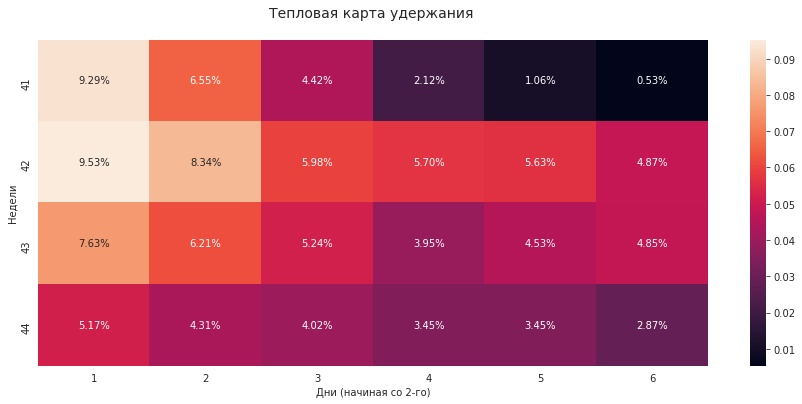

In [64]:
retention_raw, retention = get_retention(
    data, data['event_time'].dt.date.max(), 7, dimensions=['week']
)  # передаём dt в качестве параметра dimensions

# строим тепловую карту
plt.figure(figsize=(15, 6))
sns.heatmap(retention.drop(columns=['cohort_size', 0]), annot=True, fmt='.2%')
plt.title('Тепловая карта удержания \n', fontsize=14)
plt.xlabel('Дни (начиная со 2-го)')
plt.ylabel('Недели')
plt.show()

**ВЫВОДЫ**

Был выбран горизонт расчета метрики - 7 дней. Такой горизонт позволяет оценить динамику метрики `retention rate` за все 4 недели доступных в датасете данных.
Лидером по удержанию пользователей является 2ая неделя, однако к 7му дню метрики 2ой и 3ей недель сравникаются.
Худший результат по удержанию показала 1ая неделя.

## Расчет метрики "время, проведенное в приложении"

Для расчета метрики необходимо рассчитать продолжительность сессий пользователей. Под сессией будем понимать время между двумя действиями пользователя в приложении с учетом максимально возможной продолжительности сессии.

In [65]:
# Установливаем максимально возможную продолжительность сессии
s_max = 300

In [66]:
data['duration'] = (
    (data.sort_values(['user_id', 'event_time'])['event_time'].astype('int64') / 10**9) # Перевели время в секунды
    .iloc[::-1]
    .rolling(2).apply(lambda x: s_max if (x.iloc[0] - x.iloc[1]) > s_max else (x.iloc[0] - x.iloc[1]))
)

In [67]:
# Применяем максимально возможную продолжительность сессии для последних сессий пользователей
data['duration'] = data['duration'].fillna(s_max)
df = data.sort_values(['user_id', 'event_time']).reset_index()
for i in range(len(data) - 1):
    if df.loc[i, 'user_id'] != df.loc[i+1, 'user_id']:
        data.loc[df.loc[i, 'index'], 'duration'] = s_max

In [68]:
data.head()

,event_time,event_name,user_id,source,first_ts,week,duration
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00,41,1.0
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00,41,6.0
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07 00:00:02,41,54.0
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00,41,81.0
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07 00:00:02,41,24.0


**ВЫВОДЫ**

Продолжительность сессии рассчитывается как время до следующей сессии того же пользователя. Если это время больше установленного максимально возможного времени сессии, то ставится максимально возможное время.
Максимально возможное время сессии было выбрано 300 секунд как предполагаемо достаточное для данного вида сервисов.  

In [69]:
df = pd.pivot_table(
    data,
    index='user_id',
    values='duration',
    aggfunc='sum'
)
df['duration'] = df['duration'] / 60

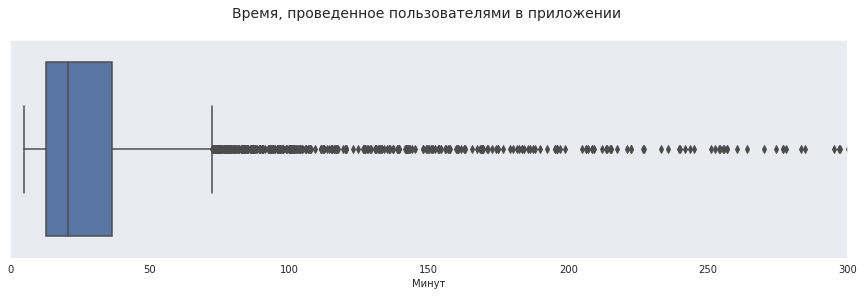

In [70]:
sns.set_style('dark')
sns.set_palette('deep')
plt.figure(figsize=(15, 4))
sns.boxplot(data=df, x='duration')
plt.xlim(0, 300)
plt.xlabel('Минут')
plt.title('Время, проведенное пользователями в приложении \n', fontsize=14)
plt.show()

**ВЫВОДЫ**

Время, проведенное пользователем в приложении за период исследования, не являющееся выбросом, не превышает 75 минут.
Медианное значение метрики - примерно 20 минут.

In [71]:
df['duration'].describe()

count    4293.000000
mean       35.293237
std        56.191408
min         5.000000
25%        12.783333
50%        20.633333
75%        36.583333
max      1238.733333
Name: duration, dtype: float64

## Расчет метрики "частота действий"

Для возможности расчета метрики в разрезе дней недели добавим в датасет столбец "день недели".

In [72]:
data['day_of_week'] = data['event_time'].apply(lambda x: x.isoweekday())

In [73]:
df = pd.pivot_table(
    data,
    index=['user_id', 'day_of_week'],
    values='event_name',
    aggfunc='count'
).reset_index()

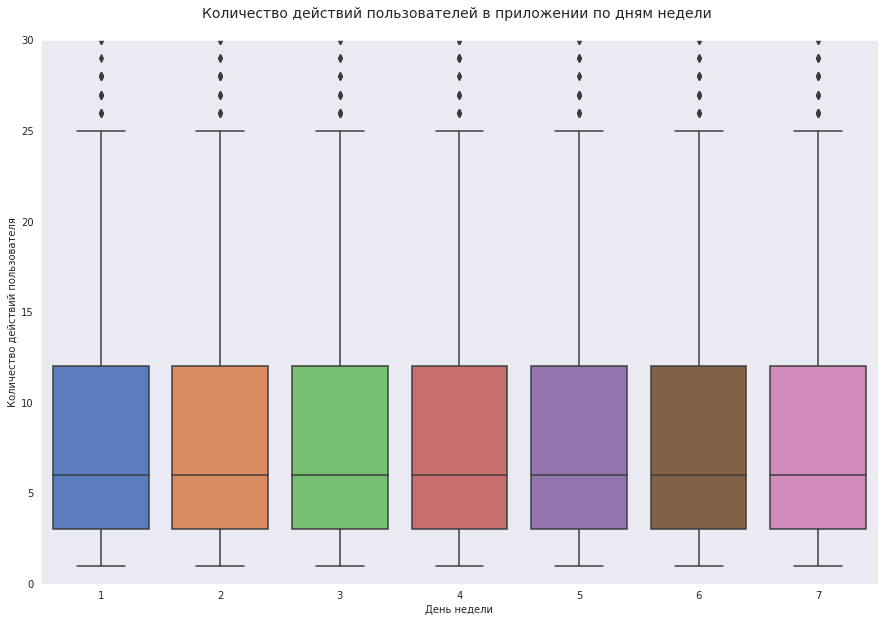

In [74]:
sns.set_style('dark')
sns.set_palette('muted')
plt.figure(figsize=(15, 10))
sns.boxplot(data=df, x='day_of_week', y='event_name')
plt.ylim(0, 30)
plt.xlabel('День недели')
plt.ylabel('Количество действий пользователя')
plt.title('Количество действий пользователей в приложении по дням недели \n', fontsize=14)
plt.show()

**ВЫВОДЫ**

В среднем пользователь совершает примерно одинаковое количество действий в приложении не зависимо от того в какой день недели он зашел в приложение.

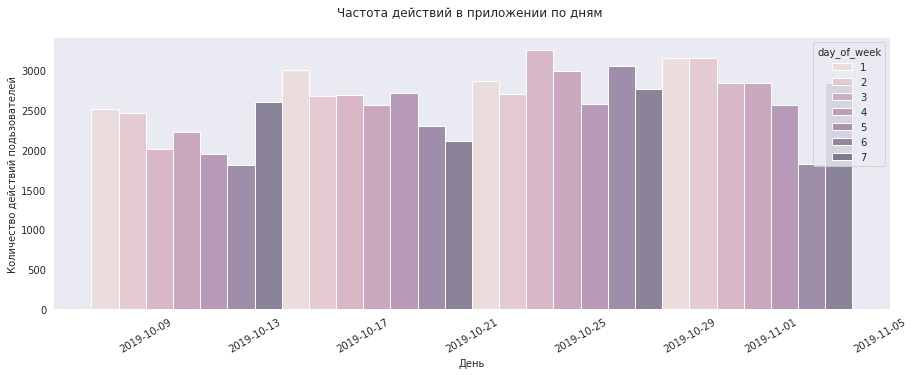

In [75]:
sns.set_style('dark')
sns.set_palette('deep')
plt.figure(figsize=(15, 5))
plt.xticks(rotation = 30)
plt.title('Частота действий в приложении по дням \n')
plt.xlabel('День')
plt.ylabel('Количество действий подьзователей')
sns.histplot(data, x='event_time', hue='day_of_week', bins=28)
plt.show()

**ВЫВОДЫ**

По выходным дням и перед ними наблюдается уменьшение количества действий пользователей, что в совокупности с предыдущим показателем говорит об уменьшении в эти дни числа заходов пользователей в приложение.

## Расчет метрики `conversion rate`

Для расчета метрики необходимо рассчитать время начала сессии, содержащей целевое действие. Таким действием является "просмотр контактов"

In [76]:
first_cont_ts = (
    data.sort_values(by=['user_id', 'event_name', 'event_time'])
    .groupby(['user_id', 'event_name'])
    .agg({'event_time': 'first'})
    .query('event_name == "contacts_show"')
    .reset_index()
    .drop('event_name', axis=1)
)
data = (
    data.merge(first_cont_ts, left_on='user_id', right_on='user_id', how = 'left')
    .rename(columns={'event_time_x': 'event_time', 'event_time_y': 'first_cont_ts'})
)
data.head()

,event_time,event_name,user_id,source,first_ts,week,duration,day_of_week,first_cont_ts
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00,41,1.0,1,NaT
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00,41,6.0,1,NaT
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07 00:00:02,41,54.0,1,NaT
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00,41,81.0,1,NaT
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07 00:00:02,41,24.0,1,NaT


In [77]:
def get_conversion(
    data,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = data.query('event_time.dt.date <= @last_suitable_acquisition_date')

    # Шаг 4. Рассчитать лайфтайм для каждой конверсии
    result_raw['lifetime'] = (
        result_raw['first_cont_ts'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):

        # Шаг 5. Построить таблицу конверсии
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )

        # Шаг 6. Посчитать сумму с накоплением для каждой строки
        result = result.fillna(0).cumsum(axis = 1)

        # Шаг 7. Вычислить размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        # Шаг 8. Объединить таблицы размеров когорт и конверсии
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        # Шаг 9. Разделить каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)

        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики конверсии
    #result_in_time = group_by_dimensions(
    #    result_raw, dimensions + ['dt'], horizon_days
    #)

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, #result_in_time

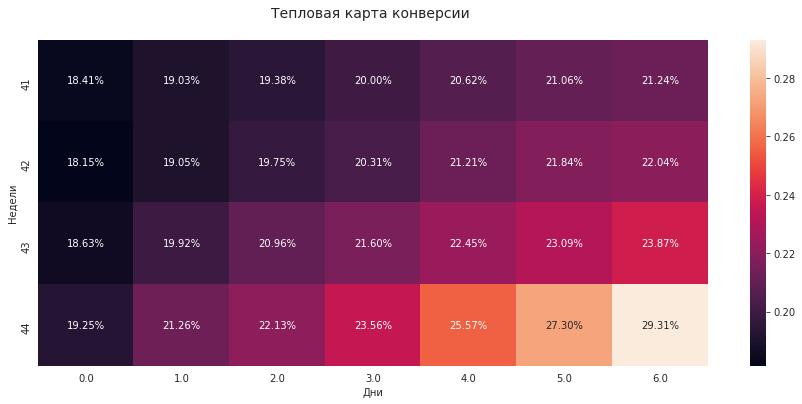

In [78]:
conversion_raw, conversion = get_conversion(
    data, data['event_time'].dt.date.max(), 7, dimensions=['week']
)

# строим хитмэп по таблице конверсии
plt.figure(figsize=(15, 6))
sns.heatmap(conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии \n', fontsize=14)
plt.xlabel('Дни')
plt.ylabel('Недели')
plt.show()

**ВЫВОДЫ**

Был выбран горизонт расчета метрики - 7 дней. Такой горизонт позволяет оценить динамику метрики `conversion rate` за все 4 недели доступных в датасете данных.
Показатель конверсии равномерно растет от неделе к неделе и достигает почти 30 % на седьмой день в последней неделе.

**ОБЩИЕ ВЫВОДЫ ПО РАЗДЕЛУ 4**

Удержание пользователей на 7ой день в зависимости от недели составляет примерно от 0.5% до 5.0%. В первую неделю удержание было наименьшим. Среднее время, проводимое пользователями в приложении за период исследования (4 недели), составляет примерно 20 минут. В начале недели пользователи более активны (чаще заходят в приложение), чем в ее конце. Самая низкая посещаемость приложения в субботу. Конверсия пользователей в просмотр контактов на 7ой день составляет примерно до 30%. Показатель конверсии плавно улучшался с каждой последующей неделей.

# Сегментация пользователей

Для сегментации пользователей на основании действий в приложении выберем параметр "время, проведенное пользователем в приложении". Распределение по сегментам произведем на основании 0.25го, 0.5го и 0.75го квартилей данного параметра. Сегменты обозначим как примерные интервалы в минутах. 

**ОБОСНОВАНИЕ СЕГМЕНТАЦИИ**

Сегментация пользователей по указанному параметру позволит определить оказывает ли влияние на основные метрики то, сколько времени пользователь проводит в приложении. Если с увеличением параметра метрики будут улучшаться, то будет иметь смысл производить разработку продукта, нацеленную на улучшение этого параметра. Одновременно нужно будет обратить внимание на пользователей, которые быстро покидают приложение и выяснить причины этого явления.

Можно предположить, что у пользователей, проводящих больше времени в приложении, метрики `retention rate` и `conversion rate` будут лучше, чем у тех, кто проводти мало времени в приложении.

Сегментация на основании квантилей разделит пользователей на одинаковые по количеству группы, что позволит в дальнейшем использовать эти группы, как весомую целевую аудиторию для доработки продукта. 

In [79]:
df = pd.pivot_table(
    data,
    index='user_id',
    values='duration',
    aggfunc='sum'
).reset_index()
quant = df['duration'].quantile([0.25, 0.5, 0.75])
quant

0.25     767.0
0.50    1238.0
0.75    2195.0
Name: duration, dtype: float64

In [80]:
for i in range(len(df)):
    if df.loc[i, 'duration'] >= quant.loc[0.75]:
        df.loc[i, 'segments'] = '45 мин и более'
    elif df.loc[i, 'duration'] >= quant.loc[0.5]:
        df.loc[i, 'segments'] = '21 - 44 мин'
    elif df.loc[i, 'duration'] >= quant.loc[0.25]:
        df.loc[i, 'segments'] = '11 - 20 мин'
    else:
        df.loc[i, 'segments'] = '0 - 10 мин'

In [81]:
data = data.merge(df.drop('duration', axis=1), left_on='user_id', right_on='user_id', how = 'left')
data.head()

,event_time,event_name,user_id,source,first_ts,week,duration,day_of_week,first_cont_ts,segments
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00,41,1.0,1,NaT,21 - 44 мин
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00,41,6.0,1,NaT,21 - 44 мин
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07 00:00:02,41,54.0,1,NaT,45 мин и более
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00,41,81.0,1,NaT,21 - 44 мин
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07 00:00:02,41,24.0,1,NaT,45 мин и более


In [82]:
data.groupby('segments')['user_id'].nunique()

segments
0 - 10 мин        1071
11 - 20 мин       1074
21 - 44 мин       1074
45 мин и более    1074
Name: user_id, dtype: int64

## Расчет метрики `retention rate` по сегментам

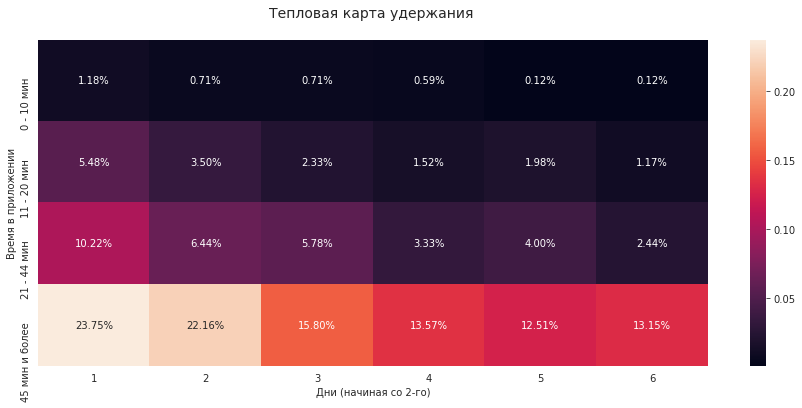

In [83]:
retention_raw, retention = get_retention(
    data, data['event_time'].dt.date.max(), 7, dimensions=['segments']
)  # передаём dt в качестве параметра dimensions

# строим тепловую карту
plt.figure(figsize=(15, 6))
sns.heatmap(retention.drop(columns=['cohort_size', 0]), annot=True, fmt='.2%')
plt.title('Тепловая карта удержания \n', fontsize=14)
plt.xlabel('Дни (начиная со 2-го)')
plt.ylabel('Время в приложении')
plt.show()

**ВЫВОДЫ**

Имеется прямая взаимосвязь времени, проведенного пользователем на сайте, и `retention rate`. Чем больше времени пользователь проводит в приложении, тем выше у него удержание и наоборот.

## Расчет метрики `conversion rate` по сегментам

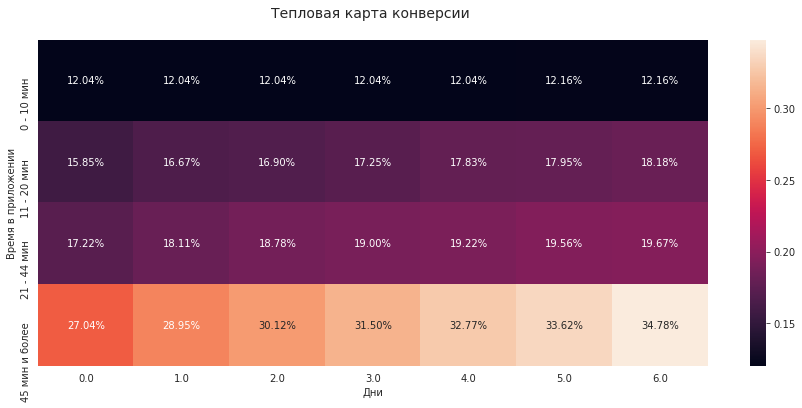

In [84]:
conversion_raw, conversion = get_conversion(
    data, data['event_time'].dt.date.max(), 7, dimensions=['segments']
)

# строим хитмэп по таблице конверсии
plt.figure(figsize=(15, 6))
sns.heatmap(conversion.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии \n', fontsize=14)
plt.xlabel('Дни')
plt.ylabel('Время в приложении')
plt.show()

**ВЫВОДЫ**

Имеется прямая взаимосвязь времени, проведенного пользователем на сайте, и `conversion rate`. Чем больше времени пользователь проводит в приложении, тем выше у него конверсия и наоборот.

# Проверка статистических гипотез (А / В тест)

## Гипотеза 1: Пользователи, установившие приложение по ссылке из `google` и по ссылке из `yandex` демонстрируют разную конверсию в просмотры контактов.

In [85]:
print(
    'Количество одних и тех же пользователей от разных источников',
    data.groupby(['source', 'user_id'], as_index=False).agg({'event_name': 'count'})['user_id'].duplicated().sum()
)

Количество одних и тех же пользователей от разных источников 0


In [86]:
print('Распределение пользователей по источникам и событиям, общее число пользователей в источниках')
events_sr = (
    data
    .pivot_table(index='event_name', columns='source', values='user_id', aggfunc='nunique', margins=True)
    .sort_values('All', ascending=False)
    .reset_index()
)
events_sr

Распределение пользователей по источникам и событиям, общее число пользователей в источниках


source,event_name,google,other,yandex,All
0,All,1129,1230,1934,4293
1,tips_show,651,840,1310,2801
2,map,354,415,687,1456
3,photos_show,363,289,443,1095
4,contacts_show,275,228,478,981
5,search_1,305,137,345,787
6,advert_open,195,259,297,751
7,search_5,137,316,210,663
8,search_4,108,203,163,474
9,favorites_add,114,77,160,351


**ГИПОТЕЗА**

Нулевая гипотеза: Различий в долях совершения пользователями действия "просмотр контактов" между группами нет.

Альтернативная гипотеза: Различия в долях совершения пользователями действия "просмотр контактов" между группами есть.

Группами являются пользователи от источников: `google` и `yandex`.

Устанавливаем уровень α = 0.05 (тест единичный). Для проверки гипотезы будем использовать статистически Z-критерий.

In [87]:
def hypothesis(i, a, b, events_sr):
    alpha = 0.05
    p1 = events_sr.iloc[i, a]/events_sr.iloc[0, a]
    p2 = events_sr.iloc[i, b]/events_sr.iloc[0, b]
    p_combined = (events_sr.iloc[i, a] + events_sr.iloc[i, b]) / (events_sr.iloc[0, a] + events_sr.iloc[0, b])
    difference = p1 - p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/events_sr.iloc[0, a] + 1/events_sr.iloc[0, b]))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p_value:', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
    print('Разница долей события', events_sr.iloc[i, 0], 'между группами составляет', difference)

In [88]:
# Проверяем гипотезы A/B-теста
i = 4
a = 1
b = 3
hypothesis(i, a, b, events_sr)

p_value: 0.8244316027993777
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Разница долей события contacts_show между группами составляет -0.003577765096730634


**ВЫВОДЫ**

Гипотеза о том, что пользователи, пришедшие из источников `google` и `yandex`, имеют разную конверсию в просмотр контактов, не подтвердилась. Статистически значимого отличия между группами нет.

## Гипотеза 2: Среднедневное время, проведенное пользователями в приложении по будним дням, отличается от аналогичного показателя по выходным дням.

Для проверки гипотезы добавляем в датасет столбец с признаком рабочего/выходного дня.

In [89]:
data['weekday'] = data['event_time'].apply(lambda x: 'weekday' if x.isoweekday() in range(6) else 'weekend')
data.head()

,event_time,event_name,user_id,source,first_ts,week,duration,day_of_week,first_cont_ts,segments,weekday
0,2019-10-07 00:00:00,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00,41,1.0,1,NaT,21 - 44 мин,weekday
1,2019-10-07 00:00:01,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00,41,6.0,1,NaT,21 - 44 мин,weekday
2,2019-10-07 00:00:02,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07 00:00:02,41,54.0,1,NaT,45 мин и более,weekday
3,2019-10-07 00:00:07,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00,41,81.0,1,NaT,21 - 44 мин,weekday
4,2019-10-07 00:00:56,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex,2019-10-07 00:00:02,41,24.0,1,NaT,45 мин и более,weekday


**ГИПОТЕЗА**

Нулевая гипотеза: Среднедневное время, проведенное пользователями в приложении в будние и выходные дни, не отличается.

Альтернативная гипотеза: Среднедневное время, проведенное пользователями в приложении в будние и выходные дни, отличается.

Устанавливаем уровень α = 0.05 (тест единичный). Для проверки гипотезы будем использовать статистически критерий Манна — Уитни.

In [90]:
print(
    'Значение p-value',
    '{0:.3f}'.format(st.mannwhitneyu(
        data[data['weekday']=='weekday']
        .groupby('user_id', as_index=False)
        .agg({'duration': 'sum'})['duration']
        ,
        data[data['weekday']=='weekend']
        .groupby('user_id', as_index=False)
        .agg({'duration': 'sum'})['duration']
    )[1])
)
print(
    'Относительное отклонение результата (группы weekend к группе weekday)',
    '{0:.3f}'.format(
        data[data['weekday']=='weekend']
        .groupby('user_id', as_index=False)
        .agg({'duration': 'sum'})['duration']
        .mean()
        /
        data[data['weekday']=='weekday']
        .groupby('user_id', as_index=False)
        .agg({'duration': 'sum'})['duration']
        .mean()
        -1)
)

Значение p-value 0.000
Относительное отклонение результата (группы weekend к группе weekday) -0.180


Отвергаем нулевую гипотезу в пользу альтернативной

**ВЫВОДЫ**

Гипотеза о том, что среднедневное время, проведенное пользователями в приложении по будним дням, отличается от аналогичного показателя по выходным дням, подтвердилась. Отличие является статистически значимым. Среднедневное время нахождения пользователей в приложении в будние дни на 18% выше, чем в выходные.

# Общие результаты работы

**ЭТАПЫ ВЫПОЛНЕННЫХ РАБОТ**

 * Предобработка и проверка на корректность данных. Изучили датасет на предмет формата данных, пропусков, целострочных дублей, полноты данных, корректности данных. После преобразования типа данных, были выявлены и удалены целострочные дубли.
 * Исследовательский анализ данных. Были расчитаны 4 метрики, 3 из них в разрезе по неделям исследования. Далее пользователи разделены на 4 сегмента по показателю "время, проведенное в приложении". Условия корректности данных соблюдены - в каждую группу попали только уникальные пользователи. Произведена оценка основных метрик: удержание и конверсия в просмотр контактов - в разрезе сегментов пользователей.
 * Анализ результатов A/B-тестов. Подготовили данные для проведения тестов в сводную таблицу. Установили уровень статистической значимости (0.05). Выбрали статистические критерии. Сформулировали нулевые и альтернативные гипотезы. В качестве сравниваемых величин выбрали конверсию (тестируемые группы: источники "yandex" и "google") и время, проведенное в приложении (тестируемые группы: посетители в будние дни и посетители в выходные дни). В первом тесте (группы yandex и google) установлено отсутствие статистически значимых различий между группами. Во втором тесте (группы будние дни и выходные дни) установлено наличие статистически значимых различий между группами.
  
**ОСНОВНЫЕ ВЫВОДЫ**

 * Между временем, проведенным пользователем в приложении, и метриками удержания и конверсии в просмотр контактов имеется прямая взаимосвязь. Чем больше времени пользователь проводит в приложении, тем лучше у него исследуемые метрики. Помимо этого выявлено, что активность пользователей в будние и выходные дни не однородна. Число посещений приложения в будние дни выше, чем в выходные. Лидером по посещаемости является понедельник, а аутсайдером - суббота.  
 * По результатам анализа A/B-тестов выявлено, что:
     1. Нет различий в конверсии пользователей, пришедших из источников "yandex" и "google".
     2. В будние дни пользователи проводят в приложении на 18% больше времени, чем в выходные дни.
 
**РЕКОМЕНДАЦИИ**

 * Провести изыскания на предмет возможности увеличения посещаемости приложения в выходные дни (особенно субботу).
 * Изучить особенности группы пользователей, чье проведенное в приложении время минимально, с целью выявления возможных причин: техничсеские проблемы в приложении, невозможность найти нужную информацию, недостаточно удобный интерфейс и т.п.
 * Маркетологам учесть одинаковую результативность от привлечения из источников "yandex" и "google".
 * Техническим специалистам привести данные к единому формату (в названиях столбцов) и устранить синонимы в значениях (столбец "имя события").